# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
import torchvision#libreria para extraer unet y unetresnet
import torch.nn.functional as F
from PIL import Image#usada para extraer las mascaras de las anotaciones coco
import zipfile
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np#imagenes y mascaras se cargan en formato numpy
import pandas as pd
import torch

In [2]:
import zipfile
device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/IA2/datasets/modelunet2alpha.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ruta):
        self.imgs = [Image.open(f"{ruta}/imgs/{i}") for i in os.listdir(f"{ruta}/imgs")]
        self.masks = [Image.open(f"{ruta}/mask/{i[:-4]}.png") for i in os.listdir(f"{ruta}/imgs")]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        mask = np.array(self.masks[idx])
        mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)#Crea una representación one-hot de la máscara. Esto es útil para tareas de clasificación multiclase en cada píxel.
        mask_oh = np.transpose(mask_oh, (2, 0, 1))#canal primera posicion (como reuqiere pytorch)
        return (np.transpose(np.array(self.imgs[idx])/255., (2, 0, 1))).astype(np.float32), mask, mask_oh

dtrain = Dataset('/content/modelunet2/train')#datos ya se encuentran separados por roboflow
dval = Dataset('/content/modelunet2/valid')
dtest = Dataset('/content/modelunet2/test')

In [13]:
img1,mask1,maskoh1 = dtrain[0]

In [14]:
img1.shape, img1.dtype,  img1.max(), img1.min()#array de numpy y en formato float

((3, 416, 416), dtype('float32'), 0.92941177, 0.0)

In [15]:
mask1.shape, mask1.dtype, mask1.max(), mask1.min()

((416, 416), dtype('uint8'), 3, 0)

In [16]:
maskoh1.shape, maskoh1.dtype, maskoh1.max(), maskoh1.min()

((3, 416, 416), dtype('float32'), 1.0, 0.0)

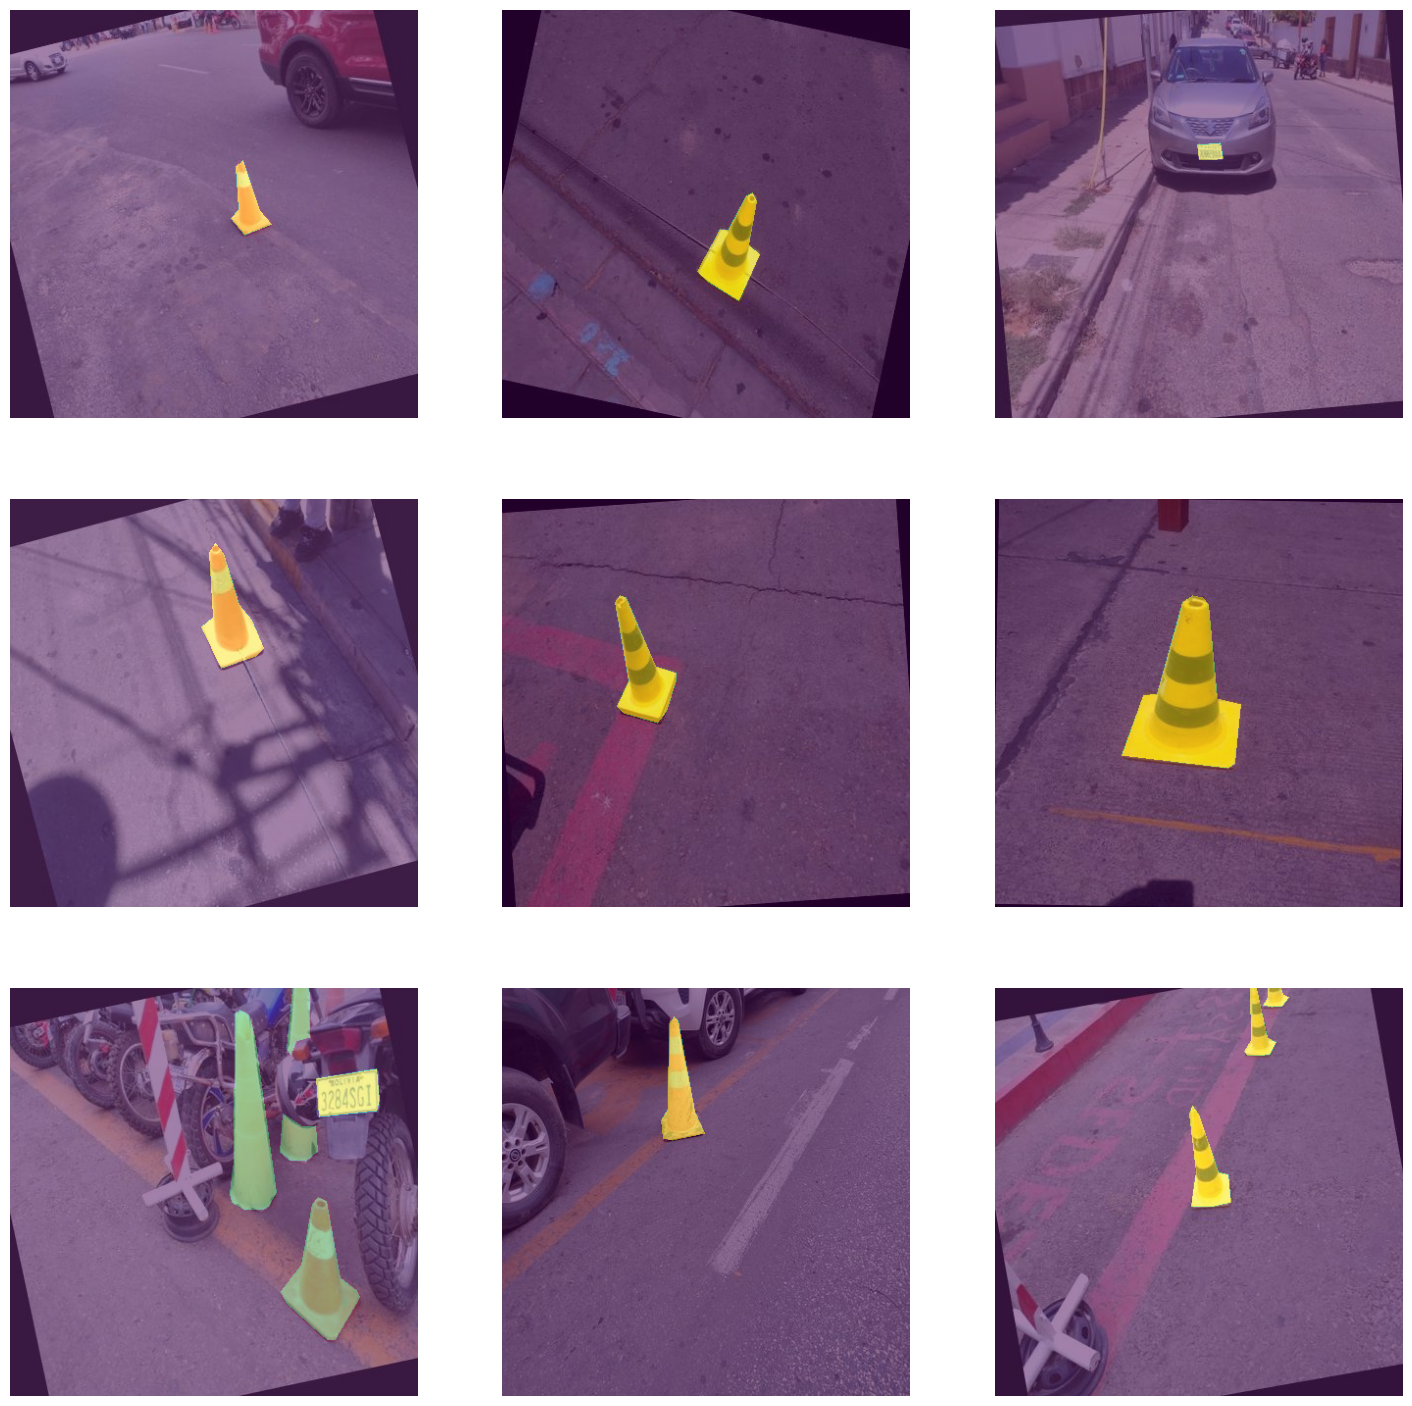

In [10]:
fig, axs = plt.subplots(3,3, figsize=(18,18))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dtrain)-1)
    img, mask, _ = dtrain[ix]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.show()

In [27]:
train_loader = torch.utils.data.DataLoader(dtrain, batch_size=16, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dval, batch_size=16, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dtest, batch_size=16, shuffle=False, pin_memory=True)
dataloader = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
len(dataloader['train'])

51

In [22]:
#unet from scratch
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, channels=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(channels, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [25]:
model = UNet(channels=3)
output = model(torch.randn((16,3,416,416)))
output.shape

torch.Size([16, 3, 416, 416])

In [20]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6

    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1):
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [34]:
def fit(model, dataloader, epochs=10, lr=0.0003):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()#binary cross entropy porque estamos usando mascras one hot
    model.to(device)
    hist = {'loss': [], 'iou': [], 'val_loss': [], 'val_iou': [],'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        train_loss, train_iou = [], []
        model.train()
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, _, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, y)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        model.eval()
        with torch.no_grad():
            val_loss, val_iou = [], []
            bar = tqdm(dataloader['val'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                val_loss.append(loss.item())
                val_iou.append(ious)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f}")
            test_loss, test_iou = [], []
            bar = tqdm(dataloader['test'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        torch.save(model.state_dict(), '/content/drive/MyDrive/IA2/Pesos/UNET/tl' + str(epoch) + '.pth')
        #/content/drive/MyDrive/IA2/Pesos/UNET
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        hist['val_loss'].append(np.mean(val_loss))
        hist['val_iou'].append(np.mean(val_iou))
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}\n")
    return hist

In [ ]:
model = UNet(in_ch=3)
hist = fit(model, dataloader, epochs=20)

test_loss 0.10101 test_iou 0.77555: 100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


Epoch 1/20 loss 0.26503 iou 0.66696 val_loss 0.10176 val_iou 0.78777 test_loss 0.10101 test_iou 0.77555



test_loss 0.06584 test_iou 0.78883: 100%|██████████| 9/9 [00:00<00:00, 18.16it/s]


Epoch 2/20 loss 0.08522 iou 0.78572 val_loss 0.06799 val_iou 0.81541 test_loss 0.06584 test_iou 0.78883



test_loss 0.04677 test_iou 0.80150: 100%|██████████| 9/9 [00:00<00:00, 19.03it/s]


Epoch 3/20 loss 0.06121 iou 0.79318 val_loss 0.05621 val_iou 0.79965 test_loss 0.04677 test_iou 0.80150



test_loss 0.03982 test_iou 0.83961: 100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


Epoch 4/20 loss 0.04957 iou 0.80826 val_loss 0.04767 val_iou 0.84309 test_loss 0.03982 test_iou 0.83961



test_loss 0.03840 test_iou 0.77543: 100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Epoch 5/20 loss 0.04130 iou 0.82054 val_loss 0.04738 val_iou 0.80572 test_loss 0.03840 test_iou 0.77543



test_loss 0.02834 test_iou 0.82051: 100%|██████████| 9/9 [00:00<00:00, 16.31it/s]


Epoch 6/20 loss 0.03904 iou 0.81502 val_loss 0.03383 val_iou 0.85687 test_loss 0.02834 test_iou 0.82051



test_loss 0.04073 test_iou 0.81297: 100%|██████████| 9/9 [00:00<00:00, 16.09it/s]


Epoch 7/20 loss 0.03532 iou 0.82950 val_loss 0.05292 val_iou 0.84045 test_loss 0.04073 test_iou 0.81297



test_loss 0.03556 test_iou 0.81700: 100%|██████████| 9/9 [00:00<00:00, 15.17it/s]


Epoch 8/20 loss 0.03244 iou 0.82181 val_loss 0.05253 val_iou 0.86270 test_loss 0.03556 test_iou 0.81700



test_loss 0.03103 test_iou 0.77692: 100%|██████████| 9/9 [00:00<00:00, 18.44it/s]


Epoch 9/20 loss 0.03294 iou 0.82454 val_loss 0.04096 val_iou 0.79851 test_loss 0.03103 test_iou 0.77692



test_loss 0.02620 test_iou 0.84448: 100%|██████████| 9/9 [00:00<00:00, 18.50it/s]


Epoch 10/20 loss 0.03023 iou 0.83372 val_loss 0.03623 val_iou 0.87848 test_loss 0.02620 test_iou 0.84448



test_loss 0.02947 test_iou 0.85030: 100%|██████████| 9/9 [00:00<00:00, 18.68it/s]


Epoch 11/20 loss 0.02788 iou 0.84251 val_loss 0.03978 val_iou 0.83904 test_loss 0.02947 test_iou 0.85030



test_loss 0.02623 test_iou 0.82786: 100%|██████████| 9/9 [00:00<00:00, 18.67it/s]


Epoch 12/20 loss 0.02818 iou 0.82874 val_loss 0.02674 val_iou 0.84851 test_loss 0.02623 test_iou 0.82786



test_loss 0.02349 test_iou 0.85645: 100%|██████████| 9/9 [00:00<00:00, 18.71it/s]


Epoch 13/20 loss 0.02770 iou 0.84067 val_loss 0.02677 val_iou 0.86017 test_loss 0.02349 test_iou 0.85645



test_loss 0.02653 test_iou 0.81855: 100%|██████████| 9/9 [00:00<00:00, 19.04it/s]


Epoch 14/20 loss 0.02580 iou 0.84381 val_loss 0.04216 val_iou 0.84469 test_loss 0.02653 test_iou 0.81855



test_loss 0.02789 test_iou 0.75931: 100%|██████████| 9/9 [00:00<00:00, 19.20it/s]


Epoch 15/20 loss 0.02417 iou 0.85377 val_loss 0.04143 val_iou 0.73938 test_loss 0.02789 test_iou 0.75931



test_loss 0.02013 test_iou 0.90812: 100%|██████████| 9/9 [00:00<00:00, 18.99it/s]


Epoch 16/20 loss 0.02231 iou 0.84650 val_loss 0.02752 val_iou 0.90985 test_loss 0.02013 test_iou 0.90812



test_loss 0.02048 test_iou 0.81951: 100%|██████████| 9/9 [00:00<00:00, 19.02it/s]


Epoch 17/20 loss 0.02162 iou 0.85112 val_loss 0.03139 val_iou 0.85478 test_loss 0.02048 test_iou 0.81951



test_loss 0.02920 test_iou 0.77629: 100%|██████████| 9/9 [00:00<00:00, 18.81it/s]


Epoch 18/20 loss 0.02208 iou 0.84363 val_loss 0.05243 val_iou 0.71892 test_loss 0.02920 test_iou 0.77629



test_loss 0.01926 test_iou 0.80243: 100%|██████████| 9/9 [00:00<00:00, 18.36it/s]


Epoch 19/20 loss 0.01982 iou 0.84066 val_loss 0.04133 val_iou 0.85713 test_loss 0.01926 test_iou 0.80243



test_loss 0.02282 test_iou 0.80261: 100%|██████████| 9/9 [00:00<00:00, 18.53it/s]

Epoch 20/20 loss 0.02055 iou 0.85341 val_loss 0.03839 val_iou 0.85343 test_loss 0.02282 test_iou 0.80261



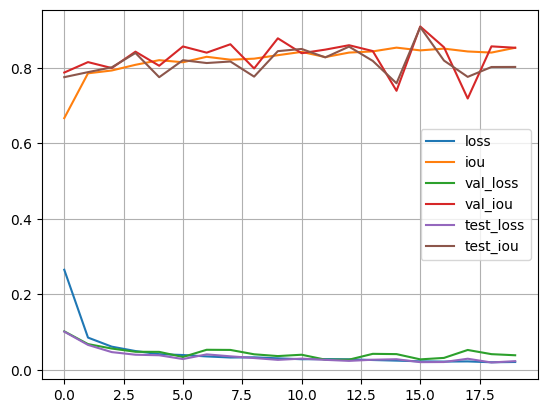

In [ ]:

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()
#perdida se estabiliza y iou ya no sube mas de 0,83(a simple vista)

(3, 416, 416)
torch.Size([3, 416, 416])


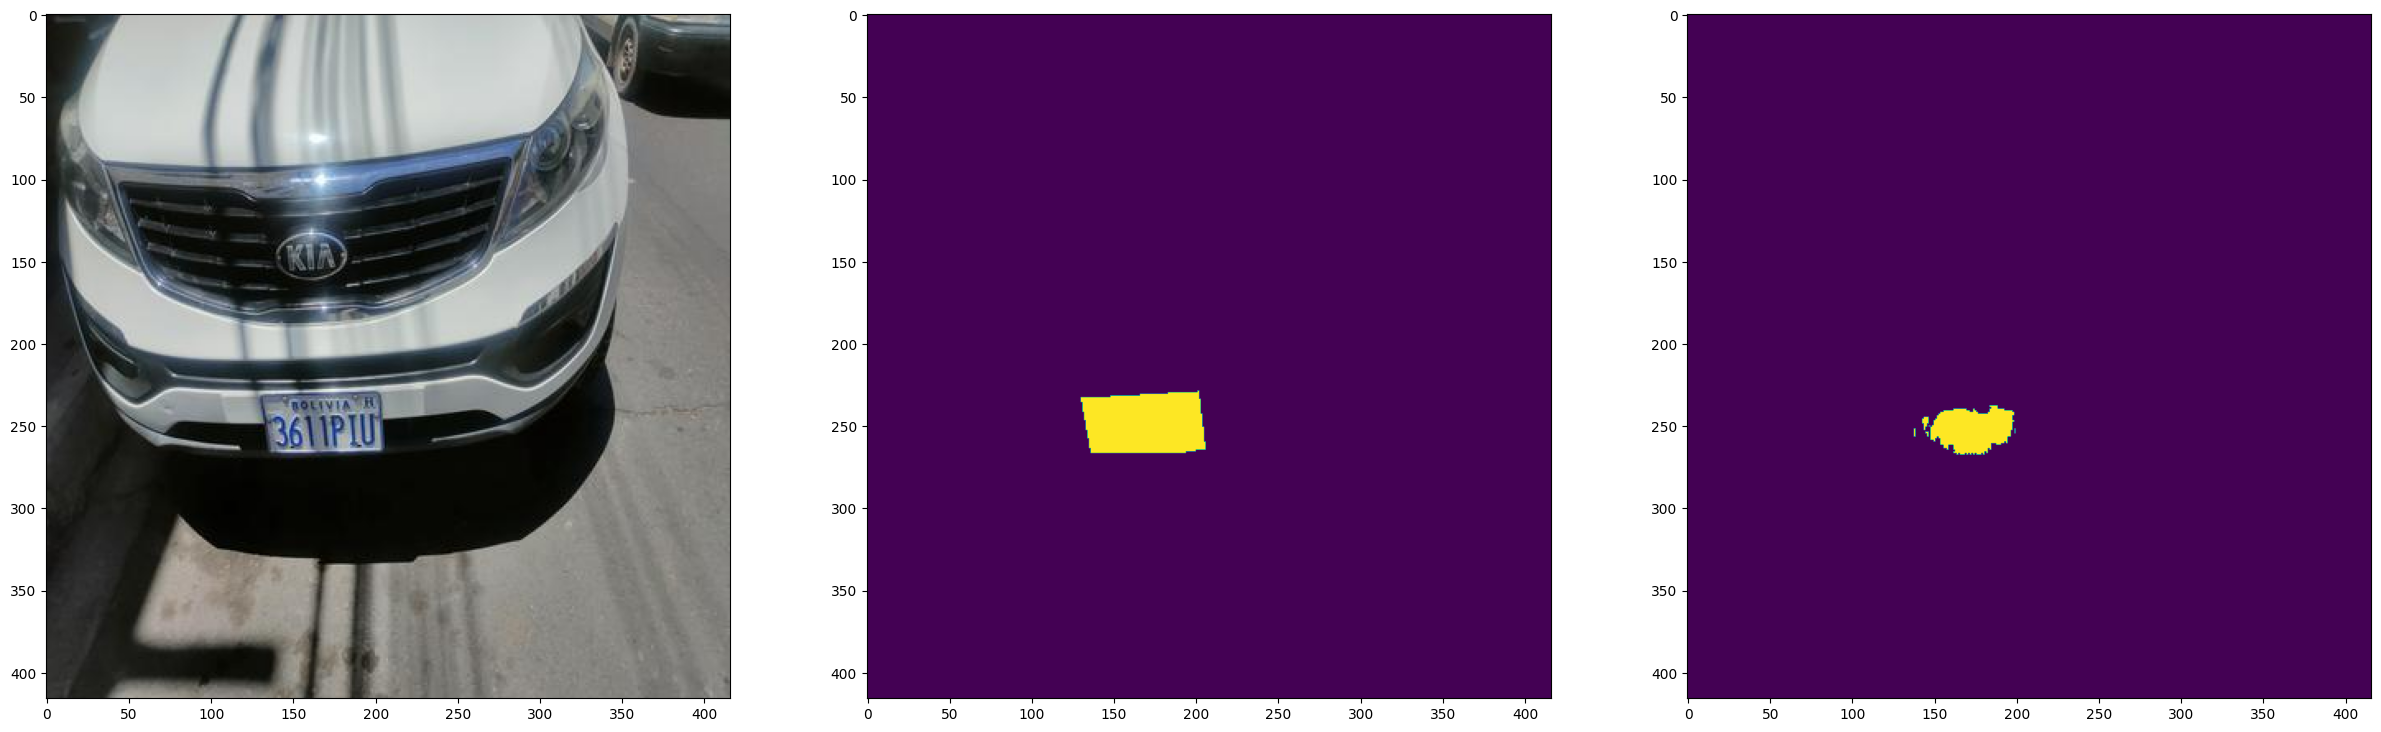

In [ ]:

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dval)-1)
    img, mask, mask_oh = dval[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)#selecciona el índice de la clase con la mayor probabilidad predicha para cada píxel.
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [29]:
import torch
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [30]:
model = UNetResnet()
output = model(torch.randn((10,3,416,416)))
output.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]
<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

torch.Size([10, 3, 416, 416])

In [31]:
model.load_state_dict(torch.load('/content/drive/MyDrive/IA2/Pesos/UNET/11.pth'))
model.train()  # Asegúrate de ponerlo en modo entrenamiento

UNetResnet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [35]:

hist = fit(model, dataloader, epochs=10)

  0%|          | 0/51 [00:00<?, ?it/s]<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.00525 test_iou 0.97994: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 1/10 loss 0.00320 iou 0.95797 val_loss 0.01279 val_iou 0.95753 test_loss 0.00525 test_iou 0.97994



test_loss 0.00719 test_iou 0.94890: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 2/10 loss 0.00374 iou 0.96535 val_loss 0.00979 val_iou 0.96975 test_loss 0.00719 test_iou 0.94890



test_loss 0.00779 test_iou 0.95840: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 3/10 loss 0.00368 iou 0.95947 val_loss 0.00814 val_iou 0.96071 test_loss 0.00779 test_iou 0.95840



test_loss 0.00625 test_iou 0.96909: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 4/10 loss 0.00307 iou 0.96965 val_loss 0.00598 val_iou 0.95929 test_loss 0.00625 test_iou 0.96909



test_loss 0.00410 test_iou 0.97040: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch 5/10 loss 0.00265 iou 0.97825 val_loss 0.00692 val_iou 0.96019 test_loss 0.00410 test_iou 0.97040



test_loss 0.00417 test_iou 0.97061: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 6/10 loss 0.00239 iou 0.97461 val_loss 0.00738 val_iou 0.97058 test_loss 0.00417 test_iou 0.97061



test_loss 0.00517 test_iou 0.99128: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 7/10 loss 0.00299 iou 0.97455 val_loss 0.00712 val_iou 0.96937 test_loss 0.00517 test_iou 0.99128



test_loss 0.01471 test_iou 0.88044: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch 8/10 loss 0.00446 iou 0.94089 val_loss 0.03068 val_iou 0.85446 test_loss 0.01471 test_iou 0.88044



test_loss 0.00684 test_iou 0.98940: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch 9/10 loss 0.00302 iou 0.95959 val_loss 0.00756 val_iou 0.96662 test_loss 0.00684 test_iou 0.98940



test_loss 0.00610 test_iou 0.97996: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 10/10 loss 0.00261 iou 0.97416 val_loss 0.00819 val_iou 0.96045 test_loss 0.00610 test_iou 0.97996



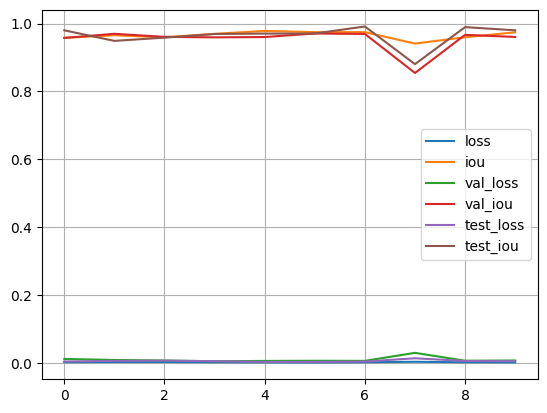

In [36]:

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()
#perdida se estabiliza y iou ya no sube mas de 0,98...y error de menos de 1%( 0.00819)

<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


(3, 416, 416)
torch.Size([3, 416, 416])


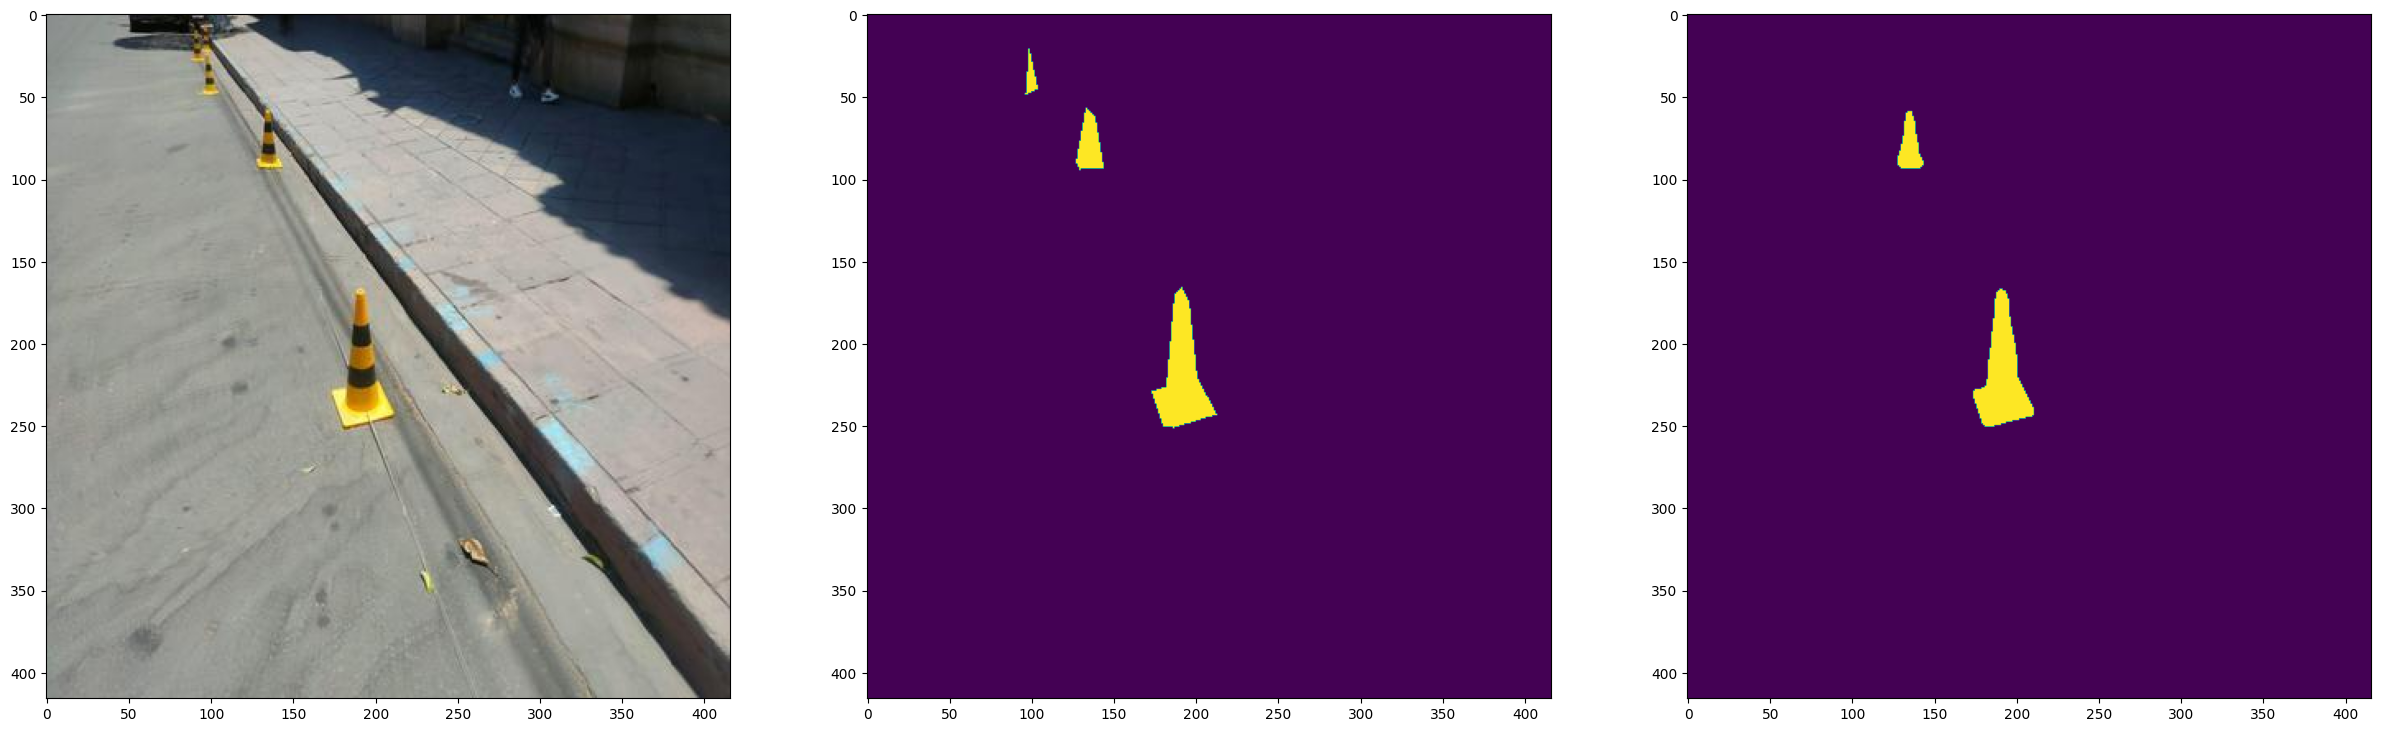

In [38]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dval)-1)
    img, mask, mask_oh = dval[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)#selecciona el índice de la clase con la mayor probabilidad predicha para cada píxel.
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


(3, 416, 416)
torch.Size([3, 416, 416])


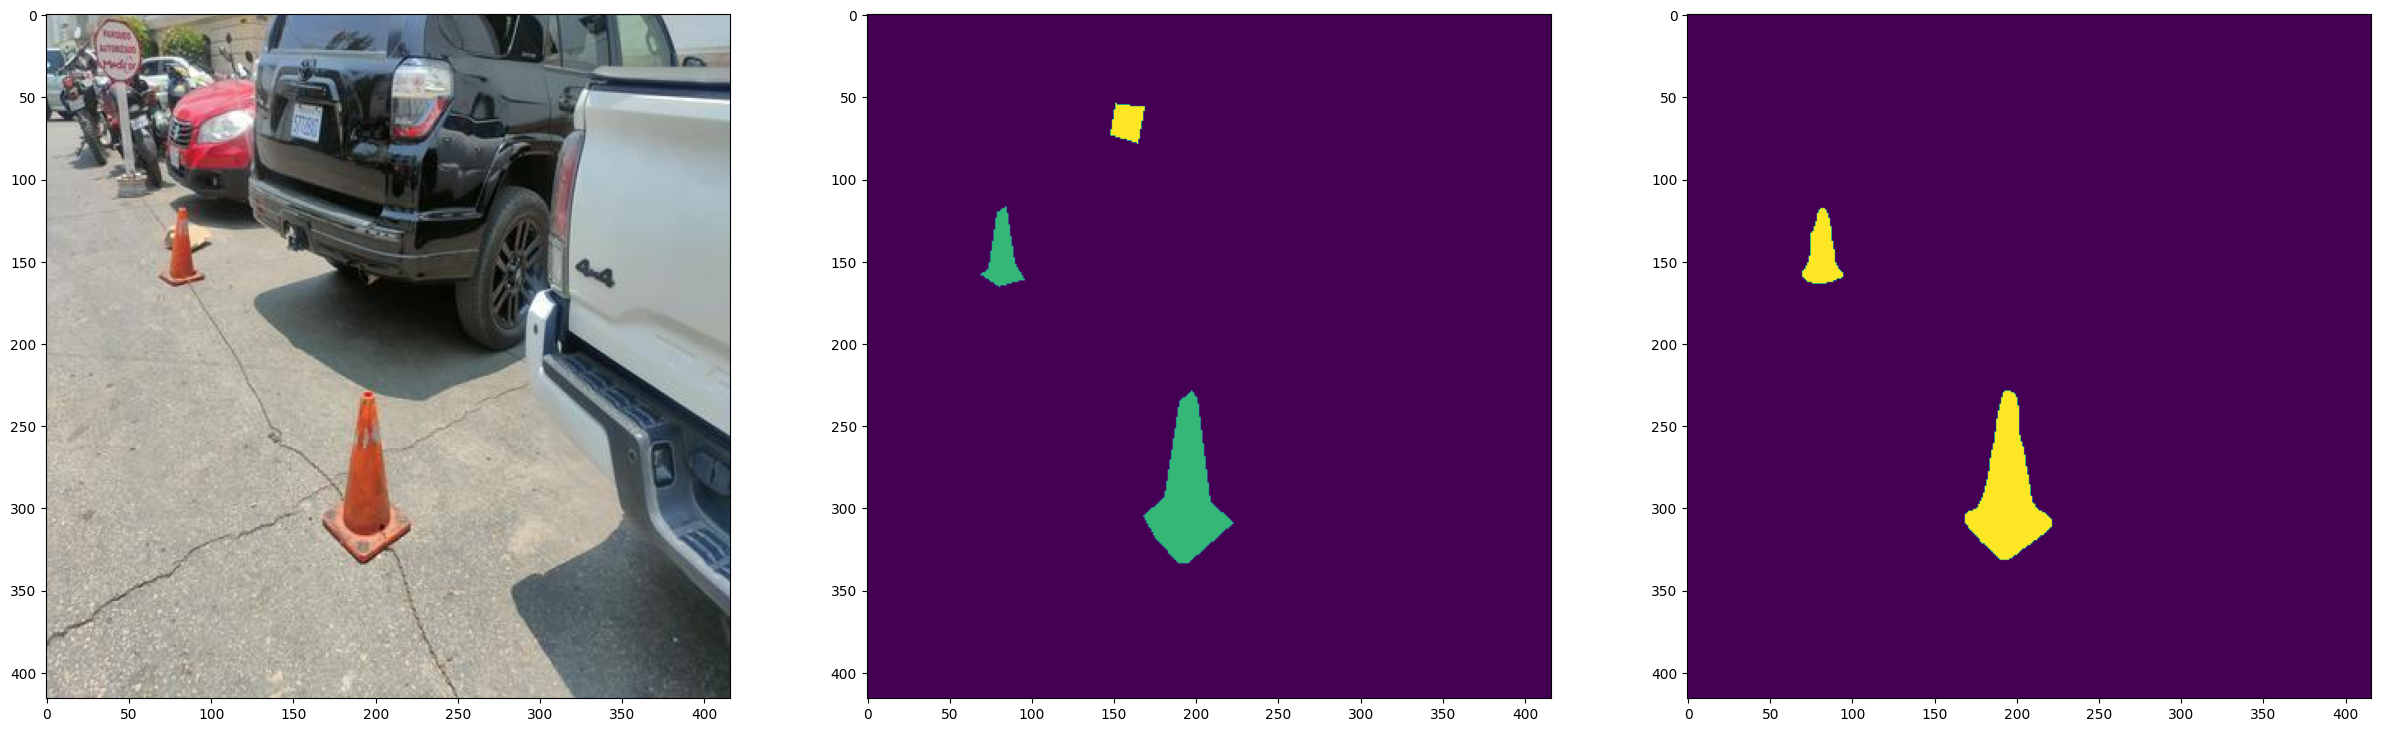

In [44]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dval)-1)
    img, mask, mask_oh = dval[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)#selecciona el índice de la clase con la mayor probabilidad predicha para cada píxel.
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


(3, 416, 416)
torch.Size([3, 416, 416])


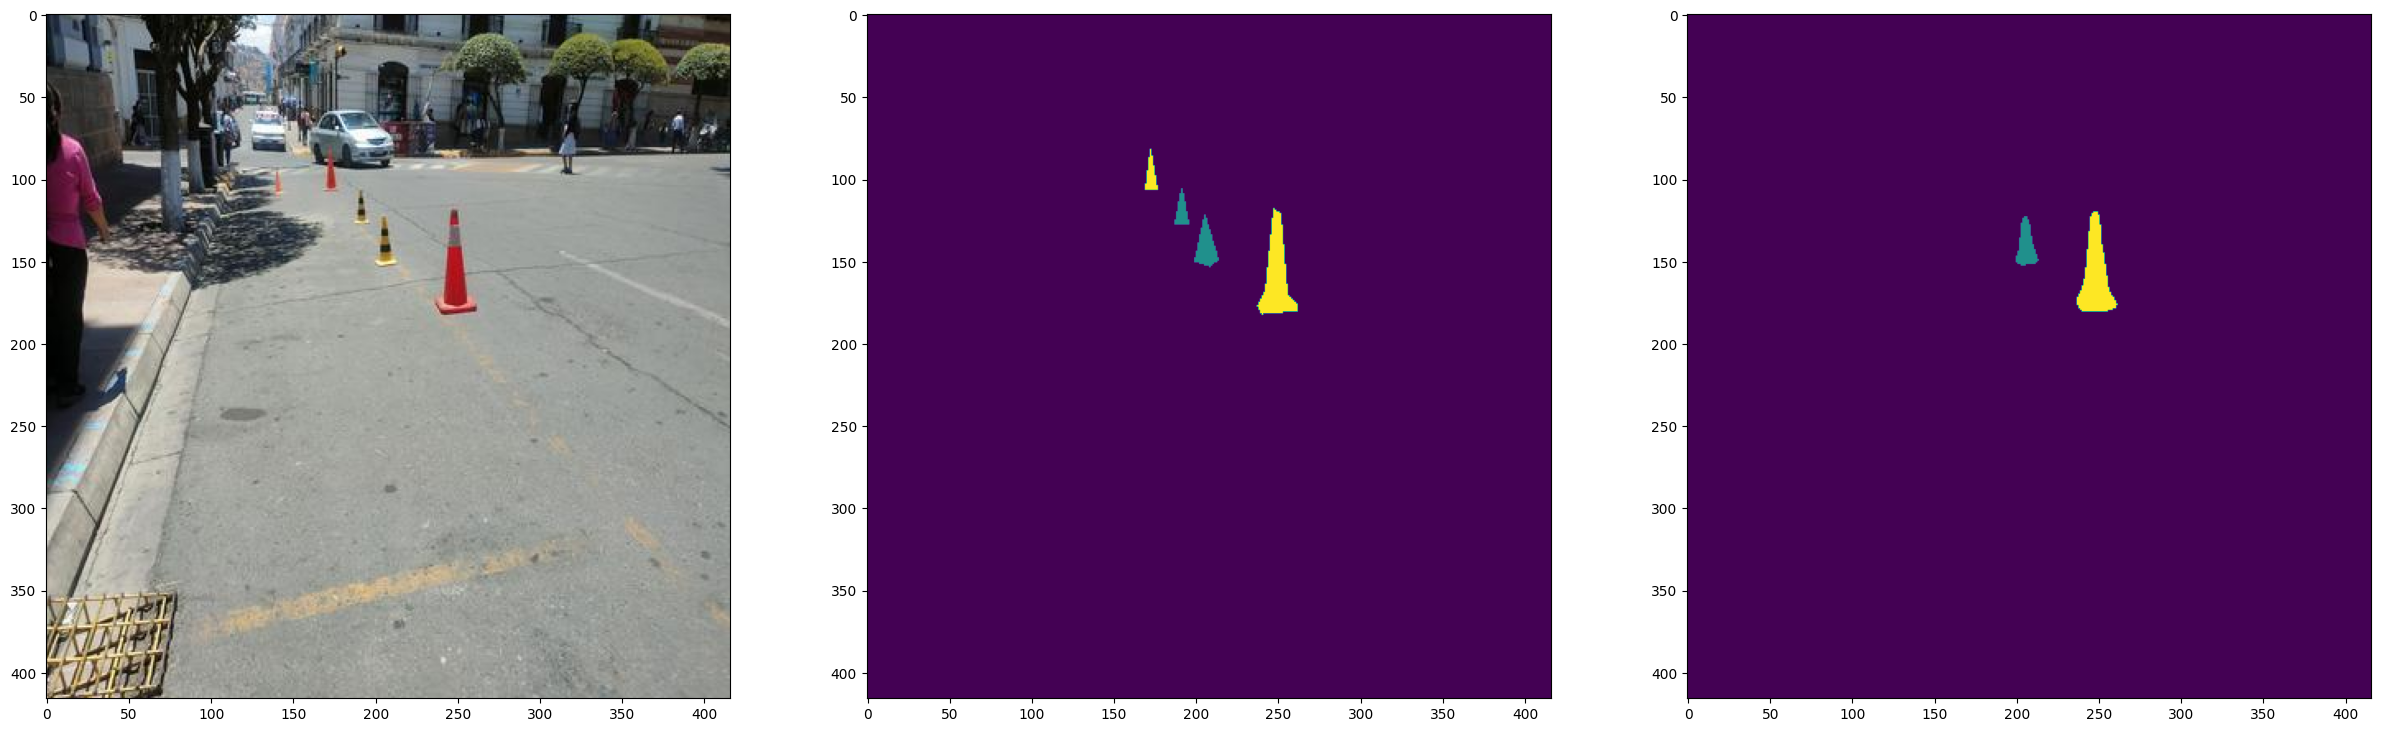

In [50]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dval)-1)
    img, mask, mask_oh = dval[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)#selecciona el índice de la clase con la mayor probabilidad predicha para cada píxel.
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

<ipython-input-29-5c1007cc5632>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


(3, 416, 416)
torch.Size([3, 416, 416])


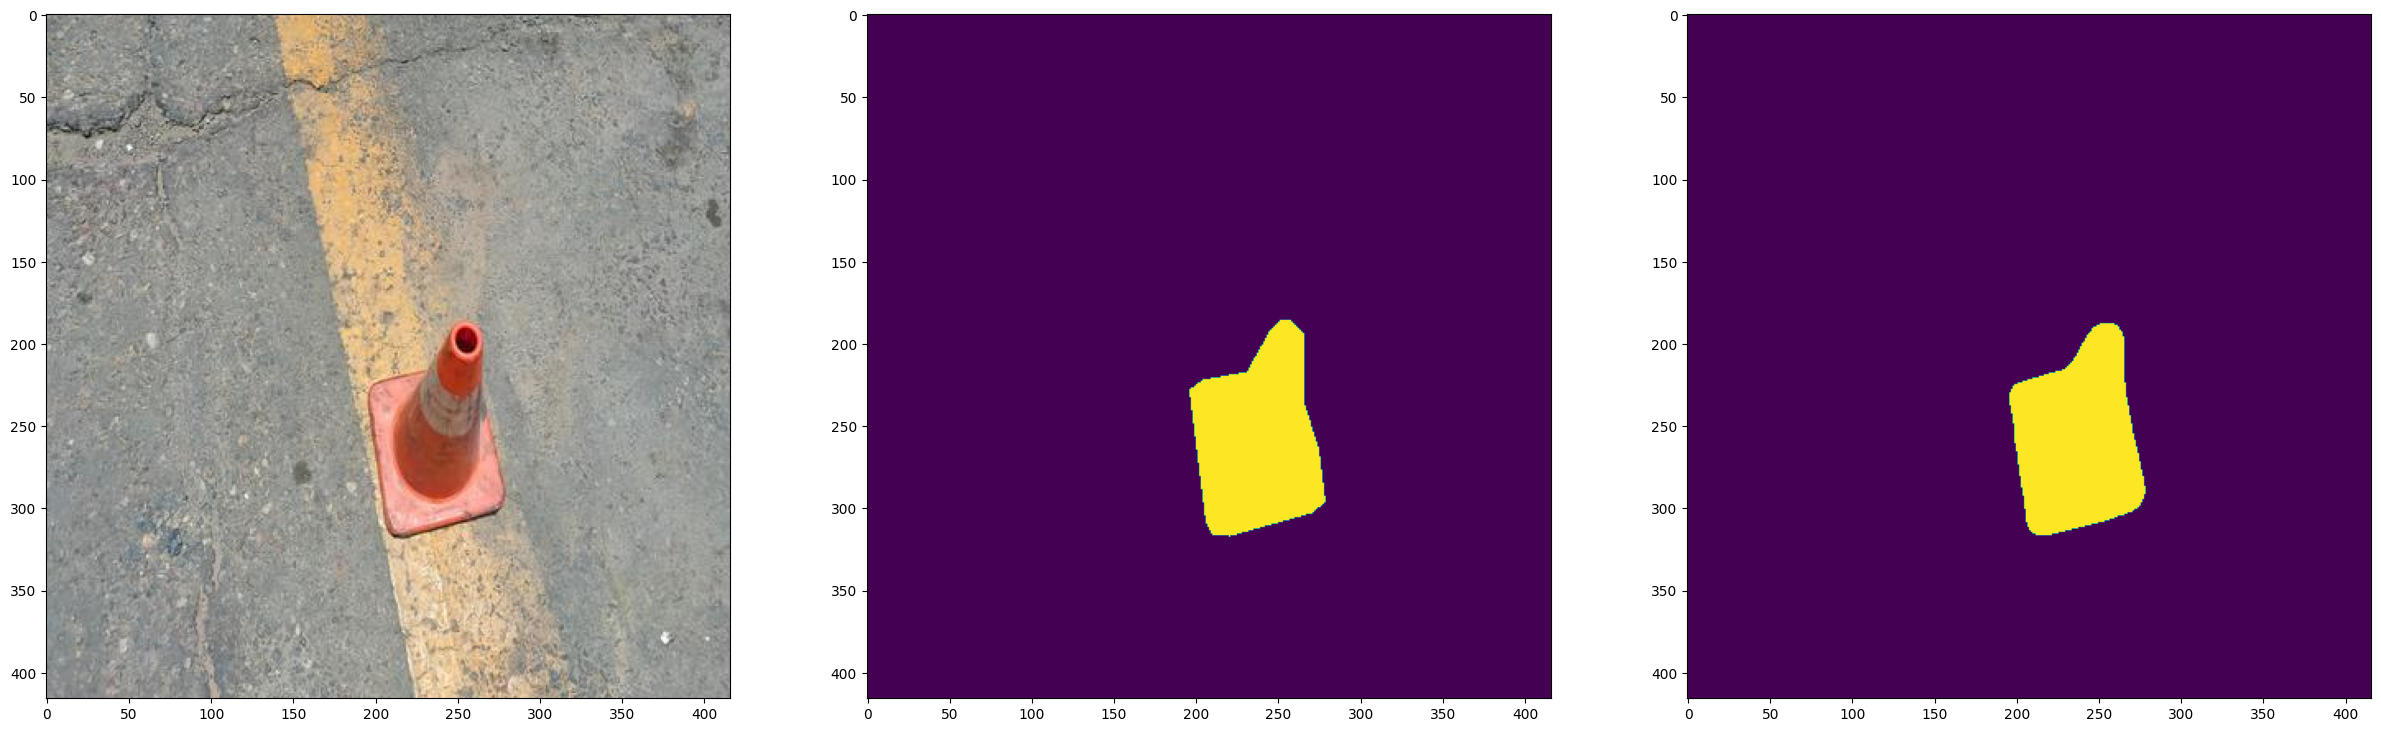

In [60]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dval)-1)
    img, mask, mask_oh = dval[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)#selecciona el índice de la clase con la mayor probabilidad predicha para cada píxel.
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()